# Neural Networks: CNN

The work of this notebook is based on the paper from Jain et al. [1][2]. A CNN is trained using semantically enriched vectors (using Word2Vec).


[1] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection on social media using semantic convolutional neural network. *International Journal of Knowledge Discovery inBioinformatics (IJKDB)*, 8(1):12–26, 2018.

[2] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection in social media using convolutional and long short term memory neural network. *Annals of Mathematics andArtificial Intelligence*, 85(1):21–44, 2019

## Imports and function definitions

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, Input, LSTM, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.metrics import accuracy_score, classification_report

In [5]:
def plot_metrics(history, validation=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    # Accuracy
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.plot(history['accuracy'])
    if validation:
        ax1.plot(history['val_accuracy'])
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss') 
    ax2.set_ylabel('Loss') 
    ax2.set_xlabel('Epoch')
    ax2.plot(history['loss'])
    if validation:
        ax2.plot(history['val_loss'])
    ax2.legend(['Train', 'Validation'], loc='upper left') 

    plt.show()

In [6]:
# Show versions
import platform
import keras
import tensorflow as tf

print(f"Python: {platform.python_version()}")
print(f"Keras: {keras.__version__}")
print(f"Tensorflow: {tf.__version__}")

Python: 3.6.9
Keras: 2.4.3
Tensorflow: 2.3.0


In [7]:
# Connect to GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data loading

In [8]:
# When using Goolge Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
base_path = "/content/drive/My Drive"

In [10]:
X_train = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-21_X_train.pkl","rb"))
X_test = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-21_X_test.pkl","rb"))
X_val = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-21_X_val.pkl","rb"))
y_train = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-21_y_train.pkl","rb"))
y_test = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-21_y_test.pkl","rb"))
y_val = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-21_y_val.pkl","rb"))

In [11]:
print(f"Training set shape {X_train.shape}")
print(f"Validation set shape {X_val.shape}")
print(f"Test set shape {X_test.shape}")

Training set shape (47607, 4539)
Validation set shape (5290, 4539)
Test set shape (22671, 4539)


In [12]:
num_classes = 2  # Number of target classes (Spam and Ham)

In [13]:
print(f"Training labels set size {y_train.shape}")
print(f"Validation labels set size {y_val.shape}")
print(f"Test labels set size {y_test.shape}")

Training labels set size (47607, 2)
Validation labels set size (5290, 2)
Test labels set size (22671, 2)


In [14]:
vocab_size = 150000
max_length = 4539

## Deeper CRNN


In [33]:
with tf.device('/device:GPU:0'):
  
  crnn_model = Sequential()

  crnn_model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_length))
  crnn_model.add(Conv1D(filters=8, kernel_size=8, activation="relu"))
  crnn_model.add(Conv1D(filters=8, kernel_size=8, activation="relu"))
  crnn_model.add(MaxPooling1D())
  crnn_model.add(Dropout(rate=0.2))
  crnn_model.add(LSTM(units=10))
  crnn_model.add(Dropout(rate=0.1))
  crnn_model.add(Flatten())
  crnn_model.add(Dense(units=num_classes, activation="softmax"))

  crnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  crnn_history = crnn_model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_val, y_val)
)

1488/1488 [==============================] - 832s 559ms/step - loss: 0.0966 - accuracy: 0.9696 - val_loss: 0.0581 - val_accuracy: 0.9802


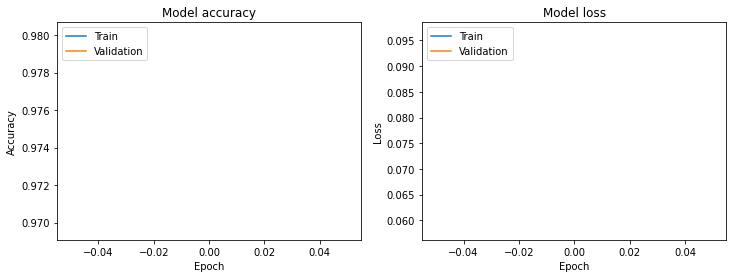

In [34]:
plot_metrics(crnn_history.history, validation=True)

In [35]:
crnn_model.save(f"{base_path}/models/2020_12_14_deeper_crnn_30")

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/2020_12_14_deeper_crnn_30/assets


In [36]:
crnn_y_train_predclass = crnn_model.predict(X_train)

sl_crnn_y_train_predclass = np.argmax(crnn_y_train_predclass, axis=1)
sl_y_train = np.argmax(y_train, axis=1)

crnn_train_accuracy = round(accuracy_score(sl_y_train, sl_crnn_y_train_predclass), 3)
print(f"Train accuracy: {crnn_train_accuracy}")

print("Train Classification Report")
print(classification_report(sl_y_train, sl_crnn_y_train_predclass))

Train accuracy: 0.991
Train Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23694
           1       1.00      0.98      0.99     23913

    accuracy                           0.99     47607
   macro avg       0.99      0.99      0.99     47607
weighted avg       0.99      0.99      0.99     47607



In [37]:
crnn_y_test_predclass = crnn_model.predict(X_test)

sl_crnn_y_test_predclass = np.argmax(crnn_y_test_predclass, axis=1)
sl_y_test = np.argmax(y_test, axis=1)

crnn_test_accuracy = round(accuracy_score(sl_y_test, sl_crnn_y_test_predclass), 3)
print(f"Test accuracy: {crnn_test_accuracy}")

print("Test Classification Report")
print (classification_report(sl_y_test, sl_crnn_y_test_predclass))

Test accuracy: 0.982
Test Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11448
           1       1.00      0.97      0.98     11223

    accuracy                           0.98     22671
   macro avg       0.98      0.98      0.98     22671
weighted avg       0.98      0.98      0.98     22671

